In this study, we look at how the difference between trolley and the average of the  neighboring stations (st 21 and 23). In this data set, the trolley is directly underneath station 22.
The difference has been made positive (absolute value of the difference)

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy
import math

#import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old
import allantools

In [2]:
def plt_unix_time_to_CST(ax):
    ax.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                        for tm in xticks], rotation=0, fontdict={'size':12, 'family':'serif'})

def difference(y, avgt):      ##Compresses an array by averaging over the given averaging time to "bin" the data, difference is a misleading name
    t = np.arange(int(avgt) , len(y), int(avgt))
    N = len(t)
    Sum = 0
    avgdiff = np.array([])
    for i in y:
        Sum += i
        if (np.where(y == i)[0][0]% avgt == 0) and (np.where(y == i)[0][0] > 0):
            avg = Sum/avgt
            Sum = 0
            avgdiff = np.append(avgdiff, avg)
            
        
    return (t,avgdiff)

def line(x,m,b): #just a line equation
    return m*x + b

def Multiplot(x_data, y_data, height, width, dimension, sublabels = None, x_axis_labels = None, y_axis_labels = None, figname = None, CST = False, daylines = False, day_offset = 0, logscale = False, day_label = ""):
    #x_data is an array containing arrays with the different data to plot
    #y_data ""
    #width is the width of the whole figure in inches
    #height is the height of the whole figure in inches
    #dimension is an array containing the dimensions of the plot figure np.array([3,2])  would correspond to 6 plots (3 rows, 2 cols)
    #x_axis_labels labels is an array containing the labels on the subplots
    #Similarly for y
    #sublabels are the titles are the subplots (1 x n array of strings), can just be 1 x 1 if all the same
    #Figname is the name of the plot
    #CST will convert the x-axis data into CST time
    #Daylines will plot red lines to show days.
    #day_offset in case we want the 24 hour mark to be somewhere else other than just 24 hours from the start
    for i in range(len(x_data)):
        if len(x_data[i]) != len(y_data[i]):
            print("The dimensions of x[" + str(i) + "] and y[" + str(i) + "] do not match")
    
    equal_x_labels = True
    for k in range(len(x_axis_labels)):
        for l in range(len(x_axis_labels)):
            if k != l:
                if  x_axis_labels[k] != x_axis_labels:
                    equal_x_labels = False
                    
    equal_y_labels = True
    for k in range(len(y_axis_labels)):
        for l in range(len(y_axis_labels)):
            if k != l:
                if  y_axis_labels[k] != y_axis_labels:
                    equal_y_labels = False
    day = np.array([86400,86400])
    fig, axs = plt.subplots(dimension[0], dimension[1], constrained_layout=True)
    fig.set_figheight(height)
    fig.set_figwidth(width)
    for i in range(dimension[0]):
        for j in range(dimension[1]):
            axs[i,j].plot(x_data[dimension[1] * i + j], y_data[dimension[1] * i + j])
            if equal_x_labels:
                axs[i,j].set_xlabel(x_axis_labels[0])
            else:
                axs[i,j].set_xlabel(x_axis_labels[dimension[1] * i + j])
            if equal_y_labels:
                axs[i,j].set_ylabel(y_axis_labels[0])
            else:
                axs[i,j].set_ylabel(y_axis_labels[dimension[1] * i + j])
            axs[i,j].set_title(sublabels[dimension[1] * i + j])
            if daylines:
                days = int((x_data[dimension[1] * i + j].max() - x_data[dimension[1] * i + j].min()) / 86400)
                for n in range(days):
                    axs[i,j].plot(day * (n+1) + day_offset + x_data[dimension[1] * i + j][0], [y_data[dimension[1] * i + j].min(), y_data[dimension[1] * i + j].max()], 'r', label = day_label)
                    axs[i,j].legend()
            if logscale:
                axs[i,j].set_xscale('log')
                axs[i,j].set_yscale('log')
            if CST:
                plt_unix_time_to_CST(axs[i,j])
    fig.suptitle(figname)

def DayLineFit(time_data, y_data, start):
    step = start
    slopes = np.array([])
    intercepts = np.array([])
    while step + 86400 <= time_data[-1]:
        x = np.array([time_data[step], time_data[step + 86400]])
        y = np.array([y_data[step],    y_data[step + 86400]])
        z = np.polyfit(x,y,1)
        slopes = np.append(slopes, z[0])
        intercept = np.append()
    return slopes, intersepts

In [3]:
filename = 'hdf5/superlong_1.h5'
sl_interp_df = pd.read_hdf(filename)
#sl_interp_df.head()

In [4]:
sl_moment_df = helper.calc_moment_df(sl_interp_df)

Finished calculating all moments for 252363 events.                 


In [5]:
#sl_moment_df.head()
run_start = sl_moment_df.index.values[0]  #I forgot to keep the times on arrays, was still getting used to CST time

In [6]:
T = sl_moment_df.index.to_numpy()

st21m1_list = sl_moment_df["st21,m1"].to_numpy()
st23m1_list = sl_moment_df["st23,m1"].to_numpy()
trm1_list   = sl_moment_df["tr,m1"].to_numpy()

st21m2_list = sl_moment_df["st21,m2"].to_numpy()
st23m2_list = sl_moment_df["st23,m2"].to_numpy()
trm2_list   = sl_moment_df["tr,m2"].to_numpy()

trm3_list   = sl_moment_df["tr,m3"].to_numpy()
st21m3_list = sl_moment_df["st21,m3"].to_numpy()
st23m3_list = sl_moment_df["st23,m3"].to_numpy()

st21m4_list = sl_moment_df["st21,m4"].to_numpy()
st23m4_list = sl_moment_df["st23,m4"].to_numpy()
trm4_list   = sl_moment_df["tr,m4"].to_numpy()

st21m5_list = sl_moment_df["st21,m5"].to_numpy()
st23m5_list = sl_moment_df["st23,m5"].to_numpy()
trm5_list   = sl_moment_df["tr,m5"].to_numpy()

st21m6_list = sl_moment_df["st21,m6"].to_numpy()
st23m6_list = sl_moment_df["st23,m6"].to_numpy()
trm6_list   = sl_moment_df["tr,m6"].to_numpy()


In [7]:
#station averages
sa1 = (st21m1_list + st23m1_list)/2
sa2 = (st21m2_list + st23m2_list)/2
sa3 = (st21m3_list + st23m3_list)/2
sa4 = (st21m4_list + st23m4_list)/2
sa5 = (st21m5_list + st23m5_list)/2
sa6 = (st21m6_list + st23m6_list)/2
# difference between the trolley and the station average
st1 = abs(trm1_list - sa1) # m1 measured by trolley is higher always             
st2 = abs(trm2_list - sa2) # m2 measured by trolley is higher always
st3 = abs(trm3_list - sa3) # m3 measured by trolley is higher always
st4 = abs(trm4_list - sa4) # m4 measured by trolley is higher always
st5 = abs(trm5_list - sa5) # m5 measured by trolley is higher always
st6 = abs(trm6_list - sa6) # m6 measured by trolley is higher always

In [8]:
t = np.logspace(0, math.log(len(st21m1_list),10), 50)  # tau values from 1 to length of columns
r = 1 # sample rate in Hz of the input data

#Computing the Allan Deviations of the differences:
(tt1, adt1, ade, adn) = allantools.oadev(st1, rate=r, data_type="freq", taus = t)  # Compute the overlapping ADEV
(tt2, adt2, ade, adn) = allantools.oadev(st2, rate=r, data_type="freq", taus = t)
(tt3, adt3, ade, adn) = allantools.oadev(st3, rate=r, data_type="freq", taus = t)  
(tt4, adt4, ade, adn) = allantools.oadev(st4, rate=r, data_type="freq", taus = t)
(tt5, adt5, ade, adn) = allantools.oadev(st5, rate=r, data_type="freq", taus = t) 
(tt6, adt6, ade, adn) = allantools.oadev(st6, rate=r, data_type="freq", taus = t) 

#time where the allan deviations are at minimum (best averaging time):
avgtt1 = tt1[np.where(adt1==adt1.min())][0]
avgtt2 = tt2[np.where(adt2==adt2.min())][0]
avgtt3 = tt3[np.where(adt3==adt3.min())][0]
avgtt4 = tt4[np.where(adt4==adt4.min())][0]
avgtt5 = tt5[np.where(adt5==adt5.min())][0]
avgtt6 = tt6[np.where(adt6==adt6.min())][0]

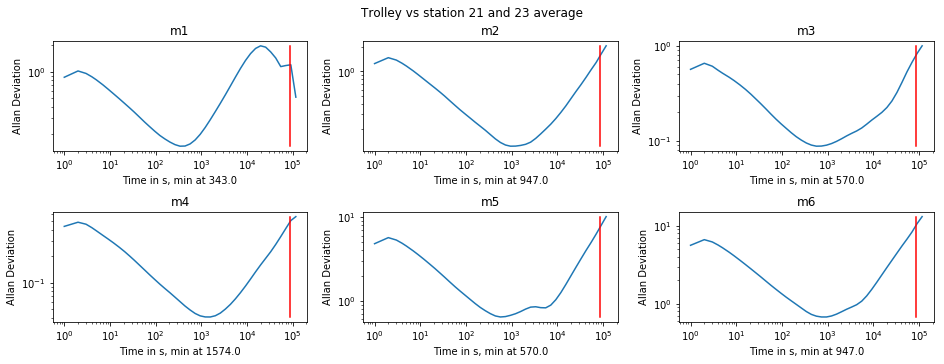

In [11]:
#Plots Allan Deviations:
day  = np.array([86400, 86400])
adt1m = np.array([min(adt1), max(adt1)]) #Trolley vs. st avg
adt2m = np.array([min(adt2), max(adt2)])
adt3m = np.array([min(adt3), max(adt3)])
adt4m = np.array([min(adt4), max(adt4)])
adt5m = np.array([min(adt5), max(adt5)])
adt6m = np.array([min(adt6), max(adt6)])

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)
axs[0,0].plot(tt1, adt1, day, adt1m, 'r')
axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel("Time in s, min at " + str(avgtt1))
axs[0,0].set_ylabel("Allan Deviation")
axs[0,0].set_title('m1')

axs[0,1].plot(tt2,adt2, day, adt2m, 'r')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlabel("Time in s, min at " + str(avgtt2))
axs[0,1].set_ylabel("Allan Deviation")
axs[0,1].set_title('m2')

axs[0,2].plot(tt3,adt3, day, adt3m, 'r')
axs[0,2].set_xscale('log')
axs[0,2].set_yscale('log')
axs[0,2].set_xlabel("Time in s, min at " + str(avgtt3))
axs[0,2].set_ylabel("Allan Deviation")
axs[0,2].set_title('m3')

axs[1,0].plot(tt4,adt4, day, adt4m, 'r')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_xlabel("Time in s, min at " + str(avgtt4))
axs[1,0].set_ylabel("Allan Deviation")
axs[1,0].set_title('m4')

axs[1,1].plot(tt5,adt5, day, adt5m, 'r')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel("Time in s, min at " + str(avgtt5))
axs[1,1].set_ylabel("Allan Deviation")
axs[1,1].set_title('m5')

axs[1,2].plot(tt6,adt6, day, adt6m, 'r')
axs[1,2].set_xscale('log')
axs[1,2].set_yscale('log')
axs[1,2].set_xlabel("Time in s, min at " + str(avgtt6))
axs[1,2].set_ylabel("Allan Deviation")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs station 21 and 23 average")

plt.show()

In [13]:
#Fitting a line to the unbinned data (Correlation)
vars1, cov1 = curve_fit(line,trm1_list, sa1)
print("m = " + str(vars1[0]) + " +- " + str(cov1[0]))
vars2, cov2 = curve_fit(line,trm2_list, sa2)
print("m = " + str(vars2[0]) + " +- " + str(cov2[0]))
vars3, cov3 = curve_fit(line,trm3_list, sa3)
print("m = " + str(vars3[0]) + " +- " + str(cov3[0]))
vars4, cov4 = curve_fit(line,trm4_list, sa4)
print("m = " + str(vars4[0]) + " +- " + str(cov4[0]))
vars5, cov5 = curve_fit(line,trm5_list, sa5)
print("m = " + str(vars5[0]) + " +- " + str(cov5[0]))
vars6, cov6 = curve_fit(line,trm6_list, sa6)
print("m = " + str(vars6[0]) + " +- " + str(cov6[0]))

m = 0.9781526226632881 +- [ 1.60591074e-08 -8.12950807e-04]
m = 0.5993236950569885 +- [2.21702957e-06 5.69998667e-05]
m = 0.3774238835989632 +- [1.36731321e-06 1.96904464e-04]
m = 0.4067386646785939 +- [1.44856133e-06 3.43904139e-04]
m = 11.098256943471883 +- [0.0005043  0.02567397]
m = -2.4831761615630263 +- [ 0.00091035 -0.11454133]


Text(0.5,0.98,'trolley and st21&23 average')

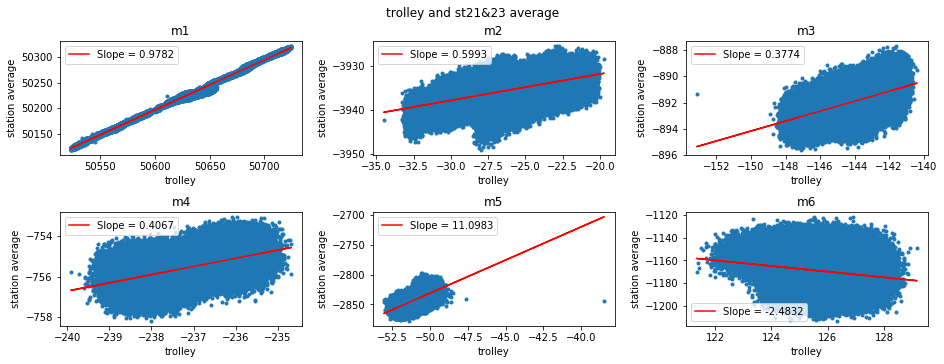

In [14]:
#Plotting the data together with the line of best fit.
fig, axs = plt.subplots(2,3, constrained_layout = True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(trm1_list, sa1,'.')
axs[0,0].plot(trm1_list, line(trm1_list, *vars1), 'r', label = "Slope = " + str(round(vars1[0], 4)))
axs[0,0].set_xlabel("trolley")
axs[0,0].set_ylabel("station average")
axs[0,0].set_title("m1")
axs[0,0].legend()

axs[0,1].plot(trm2_list, sa2,'.')
axs[0,1].plot(trm2_list, line(trm2_list, *vars2), 'r', label = "Slope = " + str(round(vars2[0], 4)))
axs[0,1].set_xlabel("trolley")
axs[0,1].set_ylabel("station average")
axs[0,1].set_title("m2")
axs[0,1].legend()

axs[0,2].plot(trm3_list, sa3,'.')
axs[0,2].plot(trm3_list, line(trm3_list, *vars3), 'r', label = "Slope = " + str(round(vars3[0], 4)))
axs[0,2].set_xlabel("trolley")
axs[0,2].set_ylabel("station average")
axs[0,2].set_title("m3")
axs[0,2].legend()

axs[1,0].plot(trm4_list, sa4,'.')
axs[1,0].plot(trm4_list, line(trm4_list, *vars4), 'r', label = "Slope = " + str(round(vars4[0], 4)))
axs[1,0].set_xlabel("trolley")
axs[1,0].set_ylabel("station average")
axs[1,0].set_title("m4")
axs[1,0].legend()

axs[1,1].plot(trm5_list, sa5,'.')
axs[1,1].plot(trm5_list, line(trm5_list, *vars5), 'r', label = "Slope = " + str(round(vars5[0], 4)))
axs[1,1].set_xlabel("trolley")
axs[1,1].set_ylabel("station average")
axs[1,1].set_title("m5")
axs[1,1].legend()

axs[1,2].plot(trm6_list, sa6,'.')
axs[1,2].plot(trm6_list, line(trm6_list, *vars6), 'r', label = "Slope = " + str(round(vars6[0], 4)))
axs[1,2].set_xlabel("trolley")
axs[1,2].set_ylabel("station average")
axs[1,2].set_title("m6")
axs[1,2].legend()

fig.suptitle("trolley and st21&23 average")

In [15]:
#Bining data
(Tts1, Dts1) =  difference(st1,avgtt1)
print("1 run(s) done")
(Tts2, Dts2) =  difference(st2,avgtt2)
print("2 run(s) done")
(Tts3, Dts3) =  difference(st3,avgtt3)
print("3 run(s) done")
(Tts4, Dts4) =  difference(st4,avgtt4)
print("4 run(s) done")
(Tts5, Dts5) =  difference(st5,avgtt5)
print("5 run(s) done")
(Tts6, Dts6) =  difference(st6,avgtt6)
print("6 run(s) done")

1 run(s) done
2 run(s) done
3 run(s) done
4 run(s) done
5 run(s) done
6 run(s) done


In [16]:
#The time was set to start at 0 in the allan deviation plots, we must add back the starting time
Tts1 = Tts1 + run_start
Tts2 = Tts2 + run_start
Tts3 = Tts3 + run_start
Tts4 = Tts4 + run_start
Tts5 = Tts5 + run_start
Tts6 = Tts6 + run_start

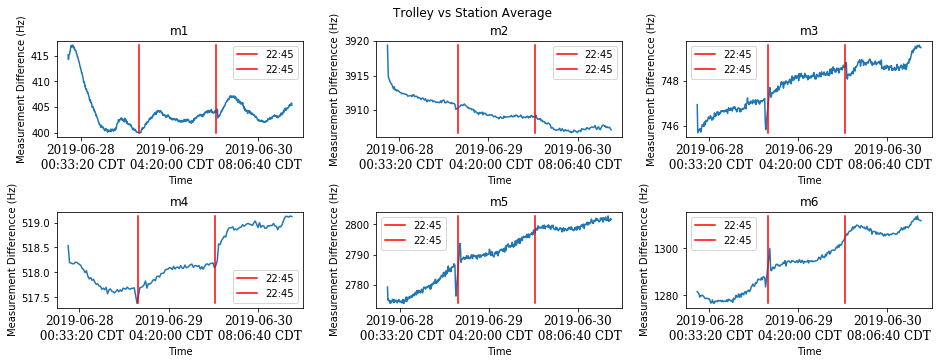

In [17]:
#plotting data
lts1 = min(Dts1) #trolley to station average
hts1 = max(Dts1)
lts2 = min(Dts2)
hts2 = max(Dts2)
lts3 = min(Dts3)
hts3 = max(Dts3)
lts4 = min(Dts4)
hts4 = max(Dts4)
lts5 = min(Dts5)
hts5 = max(Dts5)
lts6 = min(Dts6)
hts6 = max(Dts6)

fig, axs = plt.subplots(2, 3, constrained_layout=True)
fig.set_figheight(5)
fig.set_figwidth(13)

axs[0,0].plot(Tts1, Dts1)
#axs[0,0].plot(Tts1, Dts1, '.')
axs[0,0].plot(day - 6400 + run_start, [lts1,hts1], 'r', 2*day - 6400 + run_start, [lts1,hts1], 'r', label = "22:45")
axs[0,0].legend()
plt_unix_time_to_CST(axs[0,0])
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Measurement Difference (Hz)")
axs[0,0].set_title('m1')

axs[0,1].plot(Tts2, Dts2)
#axs[0,1].plot(Tts2, Dts2, '.')
axs[0,1].plot(day - 6400 + run_start, [lts2,hts2], 'r', 2*day - 6400 + run_start, [lts2,hts2], 'r', label = "22:45")
axs[0,1].legend()
plt_unix_time_to_CST(axs[0,1])
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Measurement Differencce (Hz)")
axs[0,1].set_title('m2')

axs[0,2].plot(Tts3, Dts3)
#axs[0,2].plot(Tts3, Dts3, '.')
axs[0,2].plot(day - 6400 + run_start, [lts3,hts3], 'r', 2*day - 6400 + run_start, [lts3,hts3], 'r', label = "22:45")
axs[0,2].legend()
plt_unix_time_to_CST(axs[0,2])
axs[0,2].set_xlabel("Time")
axs[0,2].set_ylabel("Measurement Differencce (Hz)")
axs[0,2].set_title('m3')

axs[1,0].plot(Tts4, Dts4)
#axs[1,0].plot(Tts4, Dts4, '.')
axs[1,0].plot(day - 6400 + run_start, [lts4,hts4], 'r', 2*day - 6400 + run_start, [lts4,hts4], 'r', label = "22:45")
axs[1,0].legend()
plt_unix_time_to_CST(axs[1,0])
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Measurement Differencce (Hz)")
axs[1,0].set_title('m4')

axs[1,1].plot(Tts5, Dts5)
#axs[1,1].plot(Tts5, Dts5, '.')
axs[1,1].plot(day - 6400 + run_start, [lts5,hts5], 'r', 2*day - 6400 + run_start, [lts5,hts5], 'r', label = "22:45")
axs[1,1].legend()
plt_unix_time_to_CST(axs[1,1])
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Measurement Differencce (Hz)")
axs[1,1].set_title('m5')

axs[1,2].plot(Tts6, Dts6)
#axs[1,2].plot(Tts6, Dts6, '.')
axs[1,2].plot(day - 6400 + run_start, [lts6,hts6], 'r', 2*day - 6400 + run_start, [lts6,hts6], 'r', label = "22:45")
axs[1,2].legend()
plt_unix_time_to_CST(axs[1,2])
axs[1,2].set_xlabel("Time")
axs[1,2].set_ylabel("Measurement Differencce (Hz)")
axs[1,2].set_title('m6')
fig.suptitle("Trolley vs Station Average")
plt.show() 
#
#plt.plot(Tts1,Dts1,".")
#plt.plot([86400, 86400], [l1, h1], "r")
#plt.plot([86400*2, 86400*2], [l1, h1], "r")
#plt.title("trm1 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts2,Dts2,".")
#plt.plot([86400, 86400], [l2, h2], "r")
#plt.plot([86400*2, 86400*2], [l2, h2], "r")
#plt.title("trm2 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts3,Dts3,".")
#plt.plot([86400, 86400], [l3, h3], "r")
#plt.plot([86400*2, 86400*2], [l3, h3], "r")
#plt.title("trm3 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts4,Dts4,".")
#plt.plot([86400, 86400], [l4, h4], "r")
#plt.plot([86400*2, 86400*2], [l4, h4], "r")
#plt.title("trm4 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts5,Dts5,".")
#plt.plot([86400, 86400], [l5, h5], "r")
#plt.plot([86400*2, 86400*2], [l5, h5], "r")
#plt.title("trm5 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()
#
#plt.plot(Tts6,Dts6,".")
#plt.plot([86400, 86400], [l6, h6], "r")
#plt.plot([86400*2, 86400*2], [l6, h6], "r")
#plt.title("trm6 and station average difference")
#plt.xlabel("time in seconds")
#plt.ylabel("difference in measurements")
#plt.show()